If you have nvidia gpu and cuda installed install torch like this for speed and happiness:

https://pytorch.org/get-started/locally/


Else if you have only cpu you can just install pytorch like this:

`pip install torch`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchsummary import summary

import pandas as pd
from torch.utils.data import Dataset

#enable gpu if possible
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

In [256]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx].expand(1,-1), self.y[idx].expand(1)


data = pd.read_csv('datasets/subject2_chest_1st100k.csv')
data = data['Chest_ECG'].to_numpy()

window_length = 100
x = []
y = []

for i in range(len(data)-window_length):
    x.append(data[i:i+window_length])
    y.append(data[i+window_length])

x, y = np.array(x), np.array(y)
train_size = int(0.8*len(x))

train_set = CustomDataset(torch.tensor(x[:train_size], dtype=torch.float), torch.tensor(y[:train_size], dtype=torch.float))
test_set = CustomDataset(torch.tensor(x[train_size:], dtype=torch.float), torch.tensor(y[train_size:], dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

In [274]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv1d(1, 32, 3, 1)
      self.conv2 = nn.Conv1d(32, 64, 3, 1)
      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.5)
      self.fc1 = nn.Linear(3072, 1)
#       self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
      x = self.conv1(x)
      x = torch.tanh(x)
      x = self.conv2(x)
      x = torch.tanh(x)

      x = F.max_pool1d(x, 2)
      x = self.dropout1(x)
      x = torch.flatten(x, 1)
    
      x = self.fc1(x)
      x = F.relu(x)
#       x = self.dropout2(x)
#       x = self.fc2(x)

#       output = F.log_softmax(x, dim=1)
      return x

net = Net().to(device)
print(net)


summary(net, (1,100))

Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3072, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 98]             128
            Conv1d-2               [-1, 64, 96]           6,208
           Dropout-3               [-1, 64, 48]               0
            Linear-4                    [-1, 1]           3,073
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.04
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [114]:
random_data = torch.rand((1, 1, 100))

my_nn = Net()
result = my_nn(random_data)
print (result)

tensor([[0.]], grad_fn=<LogSoftmaxBackward>)


In [163]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [275]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.00100205
[1,   200] loss: 0.00104777
[1,   300] loss: 0.00103797
[1,   400] loss: 0.00102303
[1,   500] loss: 0.00100627
[1,   600] loss: 0.00108262
[1,   700] loss: 0.00108574
[1,   800] loss: 0.00104045
[2,   100] loss: 0.00101820
[2,   200] loss: 0.00102688
[2,   300] loss: 0.00102658
[2,   400] loss: 0.00104360
[2,   500] loss: 0.00106263
[2,   600] loss: 0.00106043
[2,   700] loss: 0.00107107
[2,   800] loss: 0.00101837
Finished Training


In [277]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        difference = abs(outputs/labels)
        total += labels.size(0)
        correct += (torch.lt(difference, 0.5)).sum().item()
        print(difference)
        break

print('Accuracy of the network on the test set: %d %%' % (
    100 * correct / total))
print(correct)
total

tensor([[  0.0000],
        [  0.0000],
        [  0.0000],
        [  8.4299],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  7.6720],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.1230],
        [  0.7309],
        [  0.0000],
        [  0.0000],
        [  8.5800],
        [  0.0000],
        [  8.7869],
        [  0.0000],
        [  0.0000],
        [ 22.3738],
        [  0.0000],
        [  1.5457],
        [  0.0000],
        [  0.0000],
        [  8.1389],
        [ 11.2310],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  1.5538],
        [  1.6568],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000],


100

In [13]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


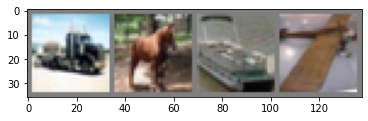

truck horse  ship plane


In [29]:
import matplotlib.pyplot as plt
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(12544, 128)
      self.fc2 = nn.Linear(128, 10)

    # x represents our data
    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      x = F.max_pool2d(x, 2)
      x = self.dropout1(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      output = F.log_softmax(x, dim=1)
      return output

net = Net().to(device)
print(net)


# summary(net, (3,32,32))

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
# Equates to one random 28x28 image
random_data = torch.rand((1, 3, 32, 32))

my_nn = Net()
result = my_nn(random_data)
print (result)

tensor([[-2.3049, -2.2811, -2.3930, -2.2530, -2.3758, -2.4194, -2.2506, -2.2333,
         -2.1800, -2.3628]], grad_fn=<LogSoftmaxBackward>)


In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.031
[1,  4000] loss: 1.765
[1,  6000] loss: 1.646
[1,  8000] loss: 1.538
[1, 10000] loss: 1.508
[1, 12000] loss: 1.464
[2,  2000] loss: 1.332
[2,  4000] loss: 1.323
[2,  6000] loss: 1.299
[2,  8000] loss: 1.267
[2, 10000] loss: 1.259
[2, 12000] loss: 1.235
Finished Training


In [119]:
type(a)
torch.cuda.is_available()

type(inputs)

device(type='cuda', index=0)

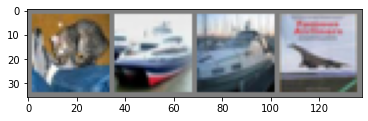

GroundTruth:    cat  ship  ship plane


In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
outputs = net(images)

In [33]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [48]:
a = torch.tensor([0,1,0])
b = torch.tensor([0,0,1])

(a == b).sum()

tensor(1)

In [40]:
type(testloader)
for data in testloader:
    print(data[0])
    print(data[1])
    print(data.shape)
    break

tensor([[[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
          [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

         [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
          [-0.6000, -0.6863, -

AttributeError: 'list' object has no attribute 'shape'

In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 66 %
Accuracy of  bird : 31 %
Accuracy of   cat : 47 %
Accuracy of  deer : 47 %
Accuracy of   dog : 37 %
Accuracy of  frog : 65 %
Accuracy of horse : 75 %
Accuracy of  ship : 71 %
Accuracy of truck : 66 %
